# Perceptrón Multicapa

Como modelo simple para ir aprendiendo el uso de PyTorch vamos a crear un perceptrón multicapa y entrenarlo con los datos en bruto.

In [85]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%reload_ext autoreload

import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
import repackage
repackage.up()

from utils import *
from fluxdataset import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
PATH = "../datos/"
TRAIN_FILE = "exoTrain.csv"
TEST_FILE = "exoTest.csv"

In [4]:
#leemos los datos de ambos datasets
df_train_raw = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_test_raw = pd.read_csv(f'{PATH}{TEST_FILE}', low_memory=False)
train_x, train_y = generate_x_y_df(df_train_raw)
train_y = train_y.add(-1) #pasamos de 1-2 a 0-1

In [5]:
train_x.shape, train_y.shape

((5087, 3197), (5087,))

In [101]:
#definicion del modelo
class Perceptron(torch.nn.Module):
    #definimos la estructura de la red
    #capa de entrada x con activacion relu
    #capa oculta con activacion relu
    #capa de salida con activacion softmax
    def __init__(self, n_features, n_hidden):
        super(Perceptron, self).__init__()
        self.fully_connected_1 = torch.nn.Linear(n_features, n_hidden)
        self.fully_connected_2 = torch.nn.Linear(n_hidden, n_hidden)
        self.fully_connected_3 = torch.nn.Linear(n_hidden, 2)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim = 1)
        #self.softmax = torch.nn.Sigmoid()
        
    #definimos el flujo 
    def forward(self, x):
        x = self.relu(self.fully_connected_1(x))
        x = self.relu(self.fully_connected_2(x))
        x = self.softmax(self.fully_connected_3(x))
        #x = self.fully_connected_3(x)
        return x

In [102]:
learning_rate = 0.01
epochs = 50
train_x_tensor = torch.tensor(train_x.values).float()
train_y_tensor = torch.tensor(train_y.values)

In [103]:
#instanciamos nuestro modelo
modelo = Perceptron(n_features = train_x.shape[1], n_hidden = 300) 

In [104]:
optimizer = torch.optim.SGD(modelo.parameters(), lr = learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [105]:
for epoch in range(epochs):
    #limpiamos los gradientes
    optimizer.zero_grad()
    #propagamos la entrada hacia delante
    predictions = modelo(train_x_tensor)
    #calculamos la perdida
    loss = loss_function(predictions.squeeze(), train_y_tensor)
    #ejecutamos back-propagation
    loss.backward()
    #actualizamos los pesos
    optimizer.step()
    #imprimimos
    if epoch % 10 == 0:
        print('Epoch: {} loss: {}'.format(epoch, loss.item()))
        
print('Epoch: {} loss: {}'.format(epochs, loss.item()))

Epoch: 0 loss: 0.6825169920921326
Epoch: 10 loss: 0.3248158395290375
Epoch: 20 loss: 0.32400718331336975
Epoch: 30 loss: 0.32347506284713745
Epoch: 40 loss: 0.3230949342250824
Epoch: 50 loss: 0.32283318042755127


In [106]:
predictions

tensor([[1.0000e+00, 1.7377e-37],
        [1.0000e+00, 1.4737e-18],
        [1.0000e+00, 0.0000e+00],
        ...,
        [1.0000e+00, 1.1166e-15],
        [9.9553e-01, 4.4728e-03],
        [1.0000e+00, 1.0477e-15]], grad_fn=<SoftmaxBackward>)

Como sospechabamos, sin hacer ningun tratamiento previo a los datos, el modelo solamente devuelve que no existe exoplaneta con certeza absoluta en practicamente todos los casos.

## Preparando los datos

- normalizar
- eliminar picos de luz

In [71]:
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_test = pd.read_csv(f'{PATH}{TEST_FILE}', low_memory=False)

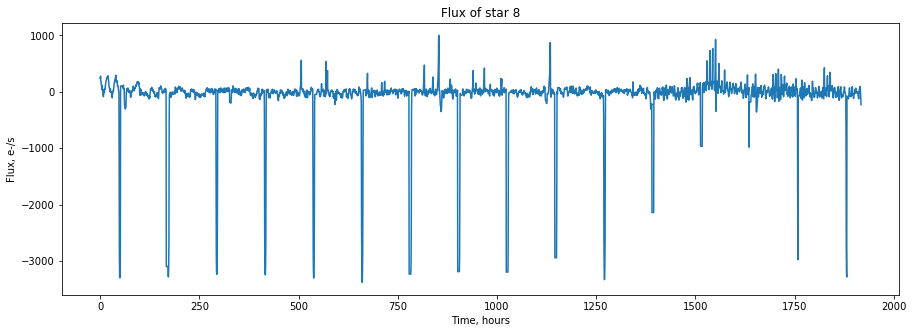

In [72]:
show_flux_plot(df_train.drop('LABEL', axis = 1), [7])

In [73]:
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:], 0.01)
df_train = z_score_normalizing(df_train)

Vemos como queda tras quitar los picos de intensidad

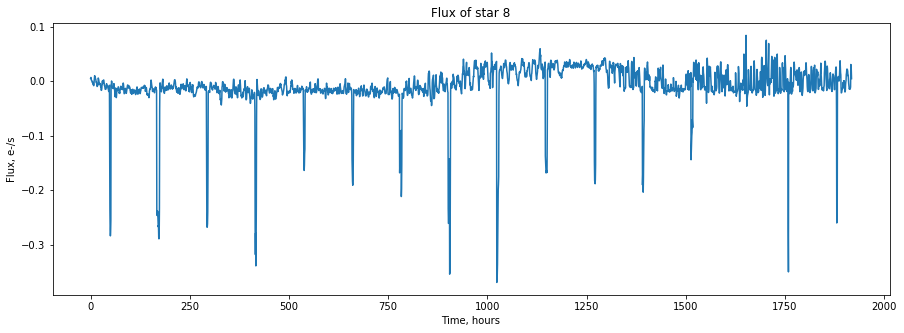

In [74]:
show_flux_plot(df_train.drop('LABEL', axis = 1), [7])

In [75]:
df_train['LABEL'] = df_train['LABEL'].add(-1)
validation_proportion = 0.2
df_train, df_validation = split_train_df(df_train, validation_proportion)
df_validation = df_validation.sample(frac=1) 

In [76]:
class Perceptron(torch.nn.Module):
    def __init__(self, output = 2):
        super(Perceptron, self).__init__()
        self.fc1 = torch.nn.Linear(3197, 1000)
        self.fc2 = torch.nn.Linear(1000, 250)
        self.fc3 = torch.nn.Linear(250, 20)
        self.fc4 = torch.nn.Linear(20, output)
        self.relu = torch.nn.ReLU()
        #self.logsoftmax = torch.nn.LogSoftmax(dim = 1)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        #x = self.logsoftmax(self.fc4(x))
        x = self.fc4(x)
        return x

In [77]:
epochs = 100
learning_rate = 0.001
alpha = 0.5
beta = 0.5
device = "cuda"

In [97]:
modelo = Perceptron().to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_sgd_cross_01"
weights = df_train['LABEL'].value_counts()
weights  = torch.tensor([max(weights)/weights[0], max(weights)/weights[1]])
criterion = torch.nn.CrossEntropyLoss(weights).to(device)
optimizer = torch.optim.SGD(modelo.parameters(), lr = learning_rate)

In [98]:
train_losses, validation_losses, scores = train(modelo, model_name, criterion, optimizer, epochs, alpha, beta,
                                                df_train, df_validation, device)

using device cuda
Score 0.4965585172176361 at epoch 0
New model saved
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361
Epoch: 0 Train loss 0.23808056465384414 Validation loss 1.313480019569397
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 0.06714290942841139 Validation loss 1.7563834190368652
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 0.049073630293112715 Validation loss 1.9969003200531006
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 0.04485847923620913 Validation loss 2.135697364807129
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 0.04348702949153703 Validation loss 2.224290370941162
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 0.04298268454080718 Validation loss 2.286349296569824
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 0.04276202553906078 Validation loss 2.3244388103485107

Score 0.4965585172176361 at epoch 71
Epoch: 71 Train loss 0.04028667006504331 Validation loss 2.4163272380828857
Score 0.4965585172176361 at epoch 72
Epoch: 72 Train loss 0.04024967066485993 Validation loss 2.419555187225342
Score 0.4965585172176361 at epoch 73
Epoch: 73 Train loss 0.04020791551697752 Validation loss 2.419797658920288
Score 0.4965585172176361 at epoch 74
Epoch: 74 Train loss 0.04017635897277907 Validation loss 2.4190008640289307
Score 0.4965585172176361 at epoch 75
Epoch: 75 Train loss 0.04011540465624385 Validation loss 2.403761386871338
Score 0.4965585172176361 at epoch 76
Epoch: 76 Train loss 0.04008960636007698 Validation loss 2.423367738723755
Score 0.4965585172176361 at epoch 77
Epoch: 77 Train loss 0.04005344318230556 Validation loss 2.424776554107666
Score 0.4965585172176361 at epoch 78
Epoch: 78 Train loss 0.040012746829658524 Validation loss 2.4283273220062256
Score 0.4965585172176361 at epoch 79
Epoch: 79 Train loss 0.0399624244293944 Validation loss 2.43853

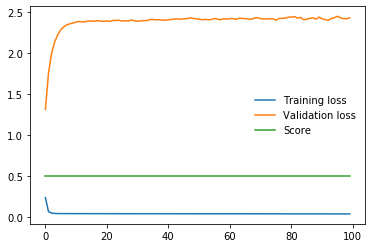

In [99]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(validation_losses, label = 'Validation loss')
plt.plot(scores, label = 'Score')
plt.legend(frameon = False)

In [100]:
modelo = Perceptron().to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_adam_cross_01"
weights = df_train['LABEL'].value_counts()
weights  = torch.tensor([max(weights)/weights[0], max(weights)/weights[1]])
criterion = torch.nn.CrossEntropyLoss(weights).to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)

In [101]:
train_losses, validation_losses, scores = train(modelo, model_name, criterion, optimizer, epochs, alpha, beta,
                                                df_train, df_validation, device)

using device cuda
Score 0.4965585172176361 at epoch 0
New model saved
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361
Epoch: 0 Train loss 0.11674166564493273 Validation loss 3.930325508117676
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 0.35245116268094695 Validation loss 4.130925178527832
Score 0.492633193731308 at epoch 2
Epoch: 2 Train loss 0.07715182729083725 Validation loss 1.6474387645721436
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 0.06477184717426722 Validation loss 4.621953010559082
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 0.06880403998735789 Validation loss 2.1808412075042725
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 0.058921636703266264 Validation loss 4.23397159576416
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 0.06707070248718637 Validation loss 5.720606327056885
Sc

Score 0.4965585172176361 at epoch 71
Epoch: 71 Train loss 0.05759750537263088 Validation loss 2.5529050827026367
Score 0.4965585172176361 at epoch 72
Epoch: 72 Train loss 3.092251347499632 Validation loss 2.3615081310272217
Score 0.4965585172176361 at epoch 73
Epoch: 73 Train loss 0.043488384289003416 Validation loss 2.3672590255737305
Score 0.4965585172176361 at epoch 74
Epoch: 74 Train loss 0.04512618015673588 Validation loss 2.2699079513549805
Score 0.4965585172176361 at epoch 75
Epoch: 75 Train loss 0.04342133869995942 Validation loss 2.3227174282073975
Score 0.4965585172176361 at epoch 76
Epoch: 76 Train loss 0.04921992604211156 Validation loss 2.3337724208831787
Score 0.4965585172176361 at epoch 77
Epoch: 77 Train loss 0.043608328868481684 Validation loss 2.368422031402588
Score 0.4965585172176361 at epoch 78
Epoch: 78 Train loss 0.043618552807800894 Validation loss 2.378998279571533
Score 0.4965585172176361 at epoch 79
Epoch: 79 Train loss 0.04361473998507938 Validation loss 2.3

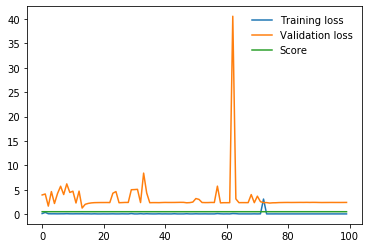

In [102]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(validation_losses, label = 'Validation loss')
plt.plot(scores, label = 'Score')
plt.legend(frameon = False)

In [111]:
modelo = Perceptron(1).to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_adam_bce_01"
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = weights[1]).to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)

In [112]:
train_losses, validation_losses, scores = train_bce(modelo, model_name, criterion, optimizer, epochs, alpha, beta,
                                                df_train, df_validation, device)

using device cuda
Score 0.4965585172176361 at epoch 0
New model saved
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361
Epoch: 0 Train loss 12.427351772829121 Validation loss 1.3458020687103271
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 1.6590126792321334 Validation loss 1.3304460048675537
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 1.3854370040228676 Validation loss 1.3338145017623901
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 1.3567467777090518 Validation loss 1.3313281536102295
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 1.3554440279850504 Validation loss 1.3303611278533936
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 2.583097660512245 Validation loss 1.3325306177139282
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 1.3789974253359238 Validation loss 1.3314458131790161
Scor

Score 0.4965585172176361 at epoch 72
Epoch: 72 Train loss 1.3799743896766727 Validation loss 1.3298057317733765
Score 0.4965585172176361 at epoch 73
Epoch: 73 Train loss 1.3795779215615855 Validation loss 1.3298588991165161
Score 0.4965585172176361 at epoch 74
Epoch: 74 Train loss 1.3790196097307181 Validation loss 1.329853892326355
Score 0.4965585172176361 at epoch 75
Epoch: 75 Train loss 1.3793983694083567 Validation loss 1.3298453092575073
Score 0.4965585172176361 at epoch 76
Epoch: 76 Train loss 1.3794790460085107 Validation loss 1.3297908306121826
Score 0.4965585172176361 at epoch 77
Epoch: 77 Train loss 1.379486973997416 Validation loss 1.3298192024230957
Score 0.4965585172176361 at epoch 78
Epoch: 78 Train loss 1.3779354213643134 Validation loss 1.3297224044799805
Score 0.4965585172176361 at epoch 79
Epoch: 79 Train loss 1.3832830278674273 Validation loss 1.3297288417816162
Score 0.4965585172176361 at epoch 80
Epoch: 80 Train loss 1.380262571514678 Validation loss 1.329719543457

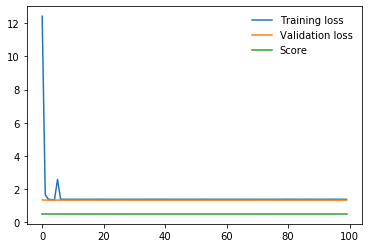

In [113]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(validation_losses, label = 'Validation loss')
plt.plot(scores, label = 'Score')
plt.legend(frameon = False)